# Modelling

---

# Contents

- [1.0 Arima Model](#1.0-ARIMA-Model)
- [2.0 Daily Data](#2.0-Daily-Data)
    - [1.1 Load Data](#2.1-Load-Data)
    - [1.2 Train Test Split](#2.2-Train-Test-Split)

In [1]:
# !pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_squared_error
from pmdarima import auto_arima
import plotly.graph_objects as go
import warnings
#warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', None)

---

# 1.0 ARIMA Model

The Arima model has 3 components:

+ Differencing Step - I - Integrated - Check for stationarity
+ Autoregressive Piece - AR - long term trends
+ Moving Average Piece - MA - Modelling sudden fluctuations

Each part has input into the model P,D,Q. I will use the previous Dickey Fuller 

+ D is the order of differencing we found using the Augmented Dickey-Fuller test.
+ P is the number of autoregressive terms in our model. PACF is used to estimate this.
+ Q is to do with looking at the moving average.
    + If PACF has a sharp cut off and lag-1 for the ACF is negative choose q to be the lag in the ACF before cut off.
    + If PACF does not have a sharp cut off or lag -1 ACF is not negative choose q = 0

Therefore based on the charts before I will use:
    
    + p = 1
    + d = 1
    + q = 0
    
However I will use auto_arima to help decide.

---

In [165]:
results = {'algo':'','name':'','date':'', 'time_frame':'','success':0,'RMSE':0, 'MSE':0, 'classification':'' }


## 1.1 Load Data

In [4]:
daily = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/daily.csv', 
                    index_col='date', parse_dates=True)

In [5]:
daily_pattern = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/targets/daily_pattern.csv', 
                           parse_dates=True)

In [6]:
daily.index

DatetimeIndex(['2000-05-30', '2000-05-31', '2000-06-01', '2000-06-02',
               '2000-06-05', '2000-06-06', '2000-06-07', '2000-06-08',
               '2000-06-09', '2000-06-12',
               ...
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23',
               '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=5045, freq=None)

In [7]:
daily.columns

Index(['open', 'high', 'low', 'close', 'marubozu', 'marubozu+1', 'marubozu-1',
       'marubozu-2', 'height', 'av_3_height', 'wk_mv_av', 'mnth_mv_av',
       'qtr_mv_av', 'day-1_open', 'day-2_open', 'day-3_open', 'day-1_high',
       'day-2_high', 'day-3_high', 'day-1_low', 'day-2_low', 'day-3_low',
       'day-1_close', 'day-2_close', 'day-3_close', 'day+1_open', 'day+1_high',
       'day+1_low', 'day+1_close', 'day+2_high', 'day+3_high', 'day+4_high',
       'day+5_high', 'date+5', 'target', 'double_height', 'select'],
      dtype='object')

In [8]:
#daily = daily.resample('B').agg({'open':'first','high':'max','low':'min', 'close':'last'})


In [9]:
daily.index

DatetimeIndex(['2000-05-30', '2000-05-31', '2000-06-01', '2000-06-02',
               '2000-06-05', '2000-06-06', '2000-06-07', '2000-06-08',
               '2000-06-09', '2000-06-12',
               ...
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23',
               '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=5045, freq=None)

In [10]:
daily_pattern['pattern_end'] = pd.to_datetime(daily_pattern['pattern_end'])

---

## 1.2 Train Test Split

In [74]:
# Test 1 date out
curr_pattern = daily.loc[daily.index == daily_pattern.loc[10]['pattern_end']].index[0]

In [116]:
test_end_date = daily.loc[daily.loc[daily.index == daily_pattern.loc[10]['pattern_end']].index[0],'date+5']

In [117]:
daily.loc[daily.index == curr_pattern]

,open,high,low,close,marubozu,marubozu+1,marubozu-1,marubozu-2,height,av_3_height,wk_mv_av,mnth_mv_av,qtr_mv_av,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+3_high,day+4_high,day+5_high,date+5,target,double_height,select
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-28,1.2597,1.271,1.2412,1.2461,-1,0.0,1.0,-1.0,-0.0136,-0.0042,1.258857,1.25686,1.181654,1.2464,1.2587,1.2707,1.2711,1.2691,1.2779,1.2442,1.2454,1.2563,1.2597,1.2464,1.2587,1.2461,1.2562,1.2365,1.2418,1.2494,1.2481,1.2601,1.2564,2004-02-04,1.2601,1.2325,1


In [118]:
train_test = daily.loc[daily.index <= test_end_date]
# train_test = daily.loc[daily.index <= '2004-2-28 00:00:00']

In [119]:
daily.loc[daily.index <= end_date]

,open,high,low,close,marubozu,marubozu+1,marubozu-1,marubozu-2,height,av_3_height,wk_mv_av,mnth_mv_av,qtr_mv_av,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+3_high,day+4_high,day+5_high,date+5,target,double_height,select
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-05-30,0.9302,0.9302,0.9302,0.9302,0,1.0,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9315,0.9382,0.9151,0.9377,0.9380,0.9498,0.9490,0.9603,2000-06-06,0.9603,0.9302,0
2000-05-31,0.9315,0.9382,0.9151,0.9377,1,-1.0,0.0,NaN,0.0062,NaN,NaN,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9376,0.9380,0.9287,0.9315,0.9498,0.9490,0.9603,0.9631,2000-06-07,0.9631,0.9439,1
2000-06-01,0.9376,0.9380,0.9287,0.9315,-1,1.0,1.0,0.0,-0.0061,0.000033,NaN,NaN,NaN,0.9315,0.9302,NaN,0.9382,0.9302,NaN,0.9151,0.9302,NaN,0.9377,0.9302,NaN,0.9313,0.9498,0.9308,0.9443,0.9490,0.9603,0.9631,0.9704,2000-06-08,0.9704,0.9254,1
2000-06-02,0.9313,0.9498,0.9308,0.9443,1,0.0,-1.0,1.0,0.0130,0.004367,NaN,NaN,NaN,0.9376,0.9315,0.9302,0.9380,0.9382,0.9302,0.9287,0.9151,0.9302,0.9315,0.9377,0.9302,0.9444,0.9490,0.9416,0.9463,0.9603,0.9631,0.9704,0.9559,2000-06-09,0.9704,0.9573,0
2000-06-05,0.9444,0.9490,0.9416,0.9463,0,1.0,1.0,-1.0,0.0019,0.002933,NaN,NaN,NaN,0.9313,0.9376,0.9315,0.9498,0.9380,0.9382,0.9308,0.9287,0.9151,0.9443,0.9315,0.9377,0.9462,0.9603,0.9456,0.9535,0.9631,0.9704,0.9559,0.9562,2000-06-12,0.9704,0.9482,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-01-29,1.2461,1.2562,1.2365,1.2418,0,0.0,-1.0,1.0,-0.0043,-0.001533,1.255871,1.256880,1.182604,1.2597,1.2464,1.2587,1.2710,1.2711,1.2691,1.2412,1.2442,1.2454,1.2461,1.2597,1.2464,1.2419,1.2494,1.2353,1.2456,1.2481,1.2601,1.2564,1.2638,2004-02-05,1.2638,1.2375,0
2004-01-30,1.2419,1.2494,1.2353,1.2456,0,0.0,0.0,-1.0,0.0037,-0.004733,1.252714,1.257013,1.183518,1.2461,1.2597,1.2464,1.2562,1.2710,1.2711,1.2365,1.2412,1.2442,1.2418,1.2461,1.2597,1.2456,1.2481,1.2394,1.2469,1.2601,1.2564,1.2638,1.2740,2004-02-06,1.2740,1.2493,0
2004-02-02,1.2456,1.2481,1.2394,1.2469,0,1.0,0.0,0.0,0.0013,0.000233,1.249314,1.257247,1.184539,1.2419,1.2461,1.2597,1.2494,1.2562,1.2710,1.2353,1.2365,1.2412,1.2456,1.2418,1.2461,1.2469,1.2601,1.2467,1.2534,1.2564,1.2638,1.2740,1.2766,2004-02-09,1.2766,1.2482,0


In [120]:
daily.loc[daily.index == daily_pattern.loc[10]['pattern_end'],'double_height']

date
2004-01-28    1.2325
Name: double_height, dtype: float64

In [121]:
target_value = daily.loc[daily.index == daily_pattern.loc[10,'pattern_end'],'double_height'].item()
target_value

1.2325

In [122]:
# def choose_exit_price(row, target_price, signal=-1):
#     if signal == -1:
#         return target_price
# #         return row['close'] - (row['height'] * 1)
#     else:
#         return target_price

# #         return row['close'] + (row['height'] * 1)

In [123]:
# train_test['double_height'] = train_test.apply(choose_exit_price, axis=1)
# train_test['double_height'] = daily.loc[daily.index == daily_pattern.loc[10,'pattern_end'],'double_height'].item()
train_test.loc[:,['double_height']] = [target_value for x in train_test.loc[:,['double_height']]]


/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [124]:
signal = daily.loc[daily.index == daily_pattern.loc[10,'pattern_end'],'marubozu'].item()
signal

-1

In [125]:
train_test.head()

,open,high,low,close,marubozu,marubozu+1,marubozu-1,marubozu-2,height,av_3_height,wk_mv_av,mnth_mv_av,qtr_mv_av,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+3_high,day+4_high,day+5_high,date+5,target,double_height,select
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-05-30,0.9302,0.9302,0.9302,0.9302,0,1.0,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9315,0.9382,0.9151,0.9377,0.9380,0.9498,0.9490,0.9603,2000-06-06,0.9603,1.2325,0
2000-05-31,0.9315,0.9382,0.9151,0.9377,1,-1.0,0.0,NaN,0.0062,NaN,NaN,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9376,0.9380,0.9287,0.9315,0.9498,0.9490,0.9603,0.9631,2000-06-07,0.9631,1.2325,1
2000-06-01,0.9376,0.9380,0.9287,0.9315,-1,1.0,1.0,0.0,-0.0061,0.000033,NaN,NaN,NaN,0.9315,0.9302,NaN,0.9382,0.9302,NaN,0.9151,0.9302,NaN,0.9377,0.9302,NaN,0.9313,0.9498,0.9308,0.9443,0.9490,0.9603,0.9631,0.9704,2000-06-08,0.9704,1.2325,1
2000-06-02,0.9313,0.9498,0.9308,0.9443,1,0.0,-1.0,1.0,0.0130,0.004367,NaN,NaN,NaN,0.9376,0.9315,0.9302,0.9380,0.9382,0.9302,0.9287,0.9151,0.9302,0.9315,0.9377,0.9302,0.9444,0.9490,0.9416,0.9463,0.9603,0.9631,0.9704,0.9559,2000-06-09,0.9704,1.2325,0
2000-06-05,0.9444,0.9490,0.9416,0.9463,0,1.0,1.0,-1.0,0.0019,0.002933,NaN,NaN,NaN,0.9313,0.9376,0.9315,0.9498,0.9380,0.9382,0.9308,0.9287,0.9151,0.9443,0.9315,0.9377,0.9462,0.9603,0.9456,0.9535,0.9631,0.9704,0.9559,0.9562,2000-06-12,0.9704,1.2325,0


In [140]:
[signal] * (len(train_test)-1)

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,


In [141]:
#train_test.loc[:,['signal']] = [signal] * (len(train_test))
# train_test.loc[:,['signal']] = [signal]
# df.insert(0, 'A', 'foo')
train_test.insert(0, 'signal', signal)

In [142]:
train_test.tail(6)

,signal,open,high,low,close,marubozu,marubozu+1,marubozu-1,marubozu-2,height,av_3_height,wk_mv_av,mnth_mv_av,qtr_mv_av,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+3_high,day+4_high,day+5_high,date+5,target,double_height,select
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-28,-1,1.2597,1.2710,1.2412,1.2461,-1,0.0,1.0,-1.0,-0.0136,-0.004200,1.258857,1.256860,1.181654,1.2464,1.2587,1.2707,1.2711,1.2691,1.2779,1.2442,1.2454,1.2563,1.2597,1.2464,1.2587,1.2461,1.2562,1.2365,1.2418,1.2494,1.2481,1.2601,1.2564,2004-02-04,1.2601,1.2325,1
2004-01-29,-1,1.2461,1.2562,1.2365,1.2418,0,0.0,-1.0,1.0,-0.0043,-0.001533,1.255871,1.256880,1.182604,1.2597,1.2464,1.2587,1.2710,1.2711,1.2691,1.2412,1.2442,1.2454,1.2461,1.2597,1.2464,1.2419,1.2494,1.2353,1.2456,1.2481,1.2601,1.2564,1.2638,2004-02-05,1.2638,1.2325,0
2004-01-30,-1,1.2419,1.2494,1.2353,1.2456,0,0.0,0.0,-1.0,0.0037,-0.004733,1.252714,1.257013,1.183518,1.2461,1.2597,1.2464,1.2562,1.2710,1.2711,1.2365,1.2412,1.2442,1.2418,1.2461,1.2597,1.2456,1.2481,1.2394,1.2469,1.2601,1.2564,1.2638,1.2740,2004-02-06,1.2740,1.2325,0
2004-02-02,-1,1.2456,1.2481,1.2394,1.2469,0,1.0,0.0,0.0,0.0013,0.000233,1.249314,1.257247,1.184539,1.2419,1.2461,1.2597,1.2494,1.2562,1.2710,1.2353,1.2365,1.2412,1.2456,1.2418,1.2461,1.2469,1.2601,1.2467,1.2534,1.2564,1.2638,1.2740,1.2766,2004-02-09,1.2766,1.2325,0
2004-02-03,-1,1.2469,1.2601,1.2467,1.2534,1,0.0,0.0,0.0,0.0065,0.003833,1.248557,1.257690,1.185702,1.2456,1.2419,1.2461,1.2481,1.2494,1.2562,1.2394,1.2353,1.2365,1.2469,1.2456,1.2418,1.2535,1.2564,1.2496,1.2532,1.2638,1.2740,1.2766,1.2792,2004-02-10,1.2792,1.2325,0
2004-02-04,-1,1.2535,1.2564,1.2496,1.2532,0,0.0,1.0,0.0,-0.0003,0.002500,1.249529,1.258117,1.186892,1.2469,1.2456,1.2419,1.2601,1.2481,1.2494,1.2467,1.2394,1.2353,1.2534,1.2469,1.2456,1.2533,1.2638,1.2531,1.2559,1.2740,1.2766,1.2792,1.2850,2004-02-11,1.2850,1.2325,0


In [143]:
start=len(train)
end=len(train)+len(test)-1
start, end

(896, 900)

In [144]:
# Set for testing
train = train_test.iloc[:start]
test = train_test.iloc[start:]

In [145]:
test.head()

,signal,open,high,low,close,marubozu,marubozu+1,marubozu-1,marubozu-2,height,av_3_height,wk_mv_av,mnth_mv_av,qtr_mv_av,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+3_high,day+4_high,day+5_high,date+5,target,double_height,select
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-29,-1,1.2461,1.2562,1.2365,1.2418,0,0.0,-1.0,1.0,-0.0043,-0.001533,1.255871,1.256880,1.182604,1.2597,1.2464,1.2587,1.2710,1.2711,1.2691,1.2412,1.2442,1.2454,1.2461,1.2597,1.2464,1.2419,1.2494,1.2353,1.2456,1.2481,1.2601,1.2564,1.2638,2004-02-05,1.2638,1.2325,0
2004-01-30,-1,1.2419,1.2494,1.2353,1.2456,0,0.0,0.0,-1.0,0.0037,-0.004733,1.252714,1.257013,1.183518,1.2461,1.2597,1.2464,1.2562,1.2710,1.2711,1.2365,1.2412,1.2442,1.2418,1.2461,1.2597,1.2456,1.2481,1.2394,1.2469,1.2601,1.2564,1.2638,1.2740,2004-02-06,1.2740,1.2325,0
2004-02-02,-1,1.2456,1.2481,1.2394,1.2469,0,1.0,0.0,0.0,0.0013,0.000233,1.249314,1.257247,1.184539,1.2419,1.2461,1.2597,1.2494,1.2562,1.2710,1.2353,1.2365,1.2412,1.2456,1.2418,1.2461,1.2469,1.2601,1.2467,1.2534,1.2564,1.2638,1.2740,1.2766,2004-02-09,1.2766,1.2325,0
2004-02-03,-1,1.2469,1.2601,1.2467,1.2534,1,0.0,0.0,0.0,0.0065,0.003833,1.248557,1.257690,1.185702,1.2456,1.2419,1.2461,1.2481,1.2494,1.2562,1.2394,1.2353,1.2365,1.2469,1.2456,1.2418,1.2535,1.2564,1.2496,1.2532,1.2638,1.2740,1.2766,1.2792,2004-02-10,1.2792,1.2325,0
2004-02-04,-1,1.2535,1.2564,1.2496,1.2532,0,0.0,1.0,0.0,-0.0003,0.002500,1.249529,1.258117,1.186892,1.2469,1.2456,1.2419,1.2601,1.2481,1.2494,1.2467,1.2394,1.2353,1.2534,1.2469,1.2456,1.2533,1.2638,1.2531,1.2559,1.2740,1.2766,1.2792,1.2850,2004-02-11,1.2850,1.2325,0


In [146]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange');

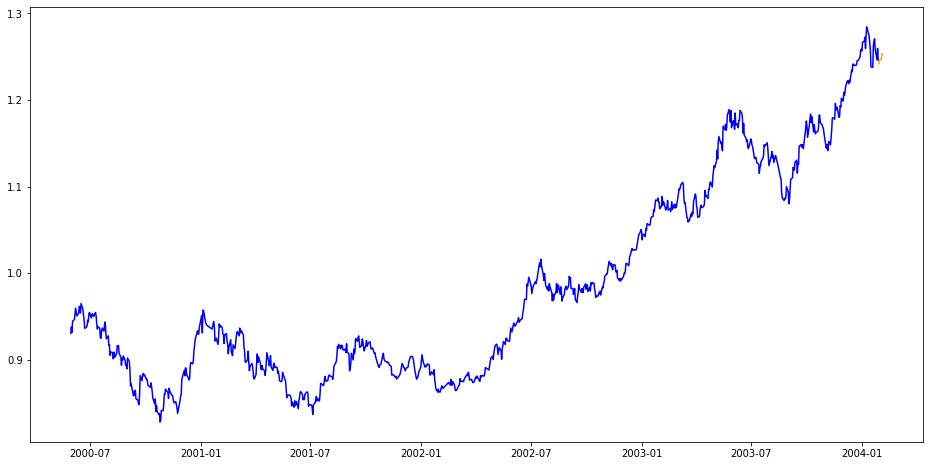

In [147]:
# This plot confirms that our train test split makes sense
train_test_plot(train['close'], test['close'])

In [148]:
auto_arima(daily['close'].dropna(), seasonal=False).summary()

/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5045
Model:               SARIMAX(0, 1, 0)   Log Likelihood               17488.067
Date:                Mon, 27 Jul 2020   AIC                         -34974.133
Time:                        18:10:21   BIC                         -34967.607
Sample:                             0   HQIC                        -34971.847
                               - 5045                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.701e-05   7.42e-07     76.831      0.000    5.56e-05    5.85e-05
===================================================================================
Ljung-Box (Q):                       31.43   Jarque-Bera (JB):              1508.87
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [149]:
train

,signal,open,high,low,close,marubozu,marubozu+1,marubozu-1,marubozu-2,height,av_3_height,wk_mv_av,mnth_mv_av,qtr_mv_av,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+3_high,day+4_high,day+5_high,date+5,target,double_height,select
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-05-30,-1,0.9302,0.9302,0.9302,0.9302,0,1.0,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9315,0.9382,0.9151,0.9377,0.9380,0.9498,0.9490,0.9603,2000-06-06,0.9603,1.2325,0
2000-05-31,-1,0.9315,0.9382,0.9151,0.9377,1,-1.0,0.0,NaN,0.0062,NaN,NaN,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9376,0.9380,0.9287,0.9315,0.9498,0.9490,0.9603,0.9631,2000-06-07,0.9631,1.2325,1
2000-06-01,-1,0.9376,0.9380,0.9287,0.9315,-1,1.0,1.0,0.0,-0.0061,0.000033,NaN,NaN,NaN,0.9315,0.9302,NaN,0.9382,0.9302,NaN,0.9151,0.9302,NaN,0.9377,0.9302,NaN,0.9313,0.9498,0.9308,0.9443,0.9490,0.9603,0.9631,0.9704,2000-06-08,0.9704,1.2325,1
2000-06-02,-1,0.9313,0.9498,0.9308,0.9443,1,0.0,-1.0,1.0,0.0130,0.004367,NaN,NaN,NaN,0.9376,0.9315,0.9302,0.9380,0.9382,0.9302,0.9287,0.9151,0.9302,0.9315,0.9377,0.9302,0.9444,0.9490,0.9416,0.9463,0.9603,0.9631,0.9704,0.9559,2000-06-09,0.9704,1.2325,0
2000-06-05,-1,0.9444,0.9490,0.9416,0.9463,0,1.0,1.0,-1.0,0.0019,0.002933,NaN,NaN,NaN,0.9313,0.9376,0.9315,0.9498,0.9380,0.9382,0.9308,0.9287,0.9151,0.9443,0.9315,0.9377,0.9462,0.9603,0.9456,0.9535,0.9631,0.9704,0.9559,0.9562,2000-06-12,0.9704,1.2325,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-01-22,-1,1.2677,1.2754,1.2638,1.2707,0,-1.0,1.0,1.0,0.0030,0.011000,1.257257,1.253513,1.177777,1.2627,1.2377,1.2383,1.2685,1.2630,1.2427,1.2550,1.2377,1.2336,1.2677,1.2627,1.2377,1.2707,1.2779,1.2563,1.2587,1.2691,1.2711,1.2710,1.2562,2004-01-29,1.2779,1.2325,0
2004-01-23,-1,1.2707,1.2779,1.2563,1.2587,-1,-1.0,0.0,1.0,-0.0120,-0.001333,1.256300,1.254713,1.178802,1.2677,1.2627,1.2377,1.2754,1.2685,1.2630,1.2638,1.2550,1.2377,1.2707,1.2677,1.2627,1.2587,1.2691,1.2454,1.2464,1.2711,1.2710,1.2562,1.2494,2004-01-30,1.2711,1.2325,0
2004-01-26,-1,1.2587,1.2691,1.2454,1.2464,-1,1.0,-1.0,0.0,-0.0123,-0.007100,1.254600,1.255570,1.179685,1.2707,1.2677,1.2627,1.2779,1.2754,1.2685,1.2563,1.2638,1.2550,1.2587,1.2707,1.2677,1.2464,1.2711,1.2442,1.2597,1.2710,1.2562,1.2494,1.2481,2004-02-02,1.2711,1.2325,0


In [150]:
model = ARIMA(train['low'], order=(0,1,0))
results = model.fit()
results.summary()

/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.low   No. Observations:                  895
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3311.137
Method:                           css   S.D. of innovations              0.006
Date:                Mon, 27 Jul 2020   AIC                          -6618.275
Time:                        18:10:23   BIC                          -6608.681
Sample:                             1   HQIC                         -6614.609
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.737      0.082   -4.46e-05       0.001
==============================================================================
"""

In [151]:
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA-0-1-0 Predictions')

/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [152]:
predictions.values

array([1.24154749, 1.24189497, 1.24224246, 1.24258994, 1.24293743])

In [153]:
type(predictions)

pandas.core.series.Series

In [154]:
def justified(row):
    
    if row['signal'] == -1 and row['low'] <= row['double_height']:
        return 1
    elif row['signal'] == 1 and row['high'] >= row['double_height']:
        return 1    
    else:
        return 0

In [164]:
outcomes = pd.DataFrame()
outcomes['low'] = test['low']
outcomes['high'] = test['high']

outcomes['preds'] = predictions.values
outcomes['double_height'] = test['double_height']
outcomes['direction'] = test['signal']
outcomes['signal_match'] = test.apply(justified, axis=1)

#daily_pre['double_height'] = daily_pre.apply(choose_exit_price, axis=1)
# outcomes.append(predictions, ignore_index=True)
outcomes

,low,high,preds,double_height,direction,signal_match
date,,,,,,
2004-01-29,1.2365,1.2562,1.241547,1.2325,-1,0
2004-01-30,1.2353,1.2494,1.241895,1.2325,-1,0
2004-02-02,1.2394,1.2481,1.242242,1.2325,-1,0
2004-02-03,1.2467,1.2601,1.242590,1.2325,-1,0
2004-02-04,1.2496,1.2564,1.242937,1.2325,-1,0


In [156]:
# predictions['date']  = test.index
#predictions.reset_index(test.index)

In [157]:
# predictions.reindex(test.index)

In [158]:
type(predictions)

pandas.core.series.Series

In [159]:
test.head()['close'].isnull().sum()

0

In [160]:
train.head()['close'].isnull().sum()

0

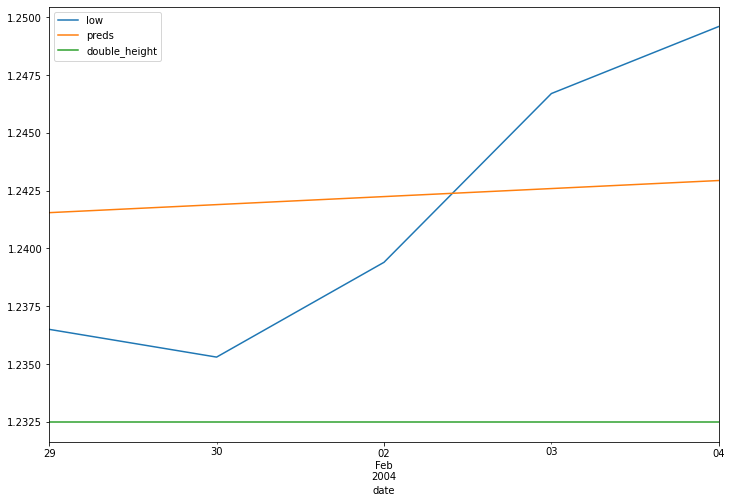

In [161]:
outcomes['low'].plot(legend=True, figsize=(12,8))
outcomes['preds'].plot(legend=True);
outcomes['double_height'].plot(legend=True);

# predictions.plot(legend=True)

In [162]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['close'], predictions)
print(f'ARIMA(0,1,0) MSE Error: {error:11.10}')

ARIMA(0,1,0) MSE Error: 5.153228272e-05


In [163]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['close'], predictions)
print(f'ARIMA(0,1,0) RMSE Error: {error:11.10}')

ARIMA(0,1,0) RMSE Error: 0.007178598938


In [166]:
results = {'algo':'','name':'','date':'', 'time_frame':'','success':'','RMSE':'', 'MSE':'', 'classification':'' }


In [ ]:
daily.columns

---

# SARIMAX


In [ ]:
# daily = daily.resample('B').agg({'open':'first','high':'max',
#                                         'low':'min', 'close':'last'})

In [ ]:
daily.index

In [ ]:
daily['close'].dropna(inplace=True)

In [ ]:
result = seasonal_decompose(daily['close'], model='add', period=400 )
result.plot();

In [ ]:
%%time
auto_arima(daily['close'], seasonal=True, maxiter=10000).summary()

In [ ]:
model = SARIMAX(train['close'], order=(0,1,0), seasonal_order=(1,0,1,12))